     f1   f2   f3   f4             name
18  5.7  3.8  1.7  0.3      Iris-setosa
20  5.4  3.4  1.7  0.2      Iris-setosa
1   4.9  3.0  1.4  0.2      Iris-setosa
83  6.0  2.7  5.1  1.6  Iris-versicolor
91  6.1  3.0  4.6  1.4  Iris-versicolor
f1       True
f2       True
f3       True
f4       True
name    False
dtype: bool


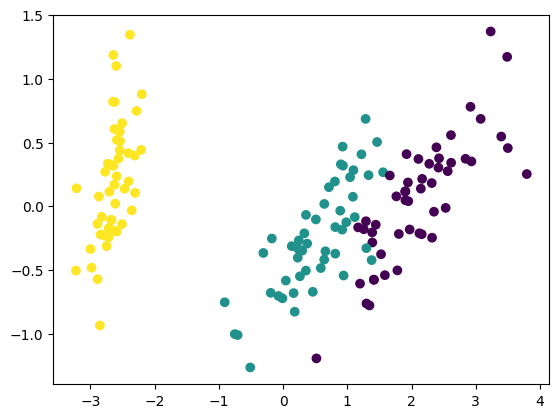

In [653]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA

iris  = pd.read_csv("iris.csv",names=["f1","f2","f3","f4","name"])
iris = iris.sample(frac=1)
print(iris.head())
print(iris.dtypes == "float")
iris_numeric = iris.select_dtypes("float")
iris_numeric_normal = (iris_numeric - iris_numeric.mean())/  iris_numeric.std()
iris.loc[:,iris.dtypes == 'float'] = iris_numeric

iris_numeric
p = PCA(n_components=2)
iris_p = pd.DataFrame(p.fit_transform(iris_numeric),columns=['x','y'])
p2 = PCA(n_components=2)
iris_p2 = pd.DataFrame(p2.fit_transform(iris_numeric_normal),columns=['x','y'])


dic = {'Iris-virginica' : 0,'Iris-versicolor' : 1,"Iris-setosa" : 2}
s2 = [dic[name] for i ,name in iris['name'].items()]
plt.scatter(iris_p['x'],iris_p['y'],label=s2,c=s2)

plt.show()



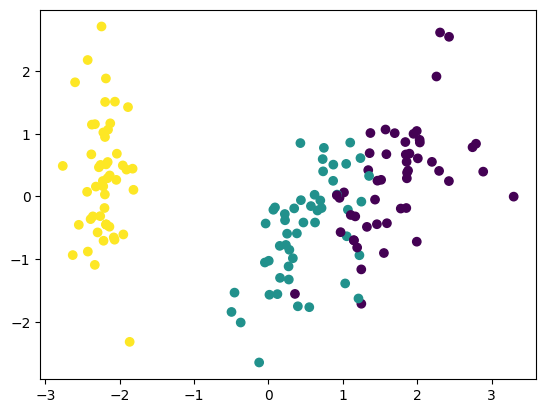

In [654]:
plt.scatter(iris_p2['x'],iris_p2['y'],label=s2,c=s2)

plt.show()

In [655]:
def getls(pop : np.array):
    ls = [np.where(pop[:-1] == i)[0] for i in range(pop[-1])]
    uniques = pop[-1]
    return uniques , ls
def getaverage(ds,l):
    avg = np.zeros((1,4))
    for ind in l:
        avg += ds[ind]
    avg /= len(l)
    return avg

In [656]:
def split(d : np.array,a : np.array,ds):
    uniques , ls = getls(a)
    cl = np.random.randint(0,uniques)
    avg = getaverage(ds,ls[cl])
    fd = max( (i for i in ls[cl]),key=lambda x : np.linalg.norm(ds[x] - avg,ord=2))
    for j in ls[cl]:
        if d[j][fd] < np.linalg.norm(ds[j] - avg):
            a[j] = 1000
    #print("a is")
    #print(a)
    return a

In [657]:
def merge(d : np.array,a : np.array,ds):
    uniques , ls = getls(a)
    cl = np.random.randint(0,uniques)
    if uniques == 1:
        return a
    avg = getaverage(ds,ls[cl])
    #print(avg)
    #print(cl)
    best = None
    bestcl = None
    for i in range(uniques):
        if i == cl : continue
        dist = 0
        for j in ls[i]:
            dist += np.linalg.norm(avg - ds[j],ord=2)
        if len(ls[i]) == 0:
            #should not happen
            continue
        dist /= len(ls[i])
        if best == None or dist < best:
            best = dist
            bestcl = i
    for j in ls[bestcl]:
        a[j] = cl
    return a           
        
        
            

In [658]:
def combine(d: np.array ,a : np.array,b : np.array,ds):
    ua , ub = a[-1] , b[-1]
    if ua == 1 :
        return a ,b
    if ub == 1 :
        return a,b
    ca = np.random.choice(np.arange(1,ua+1),size=np.random.randint(min(3,ua),ua + 1),replace=False)
    cb = np.random.choice(np.arange(1,ub+1),size=np.random.randint(min(3,ub),ub + 1),replace=False)
    uniques ,ls = getls(a)
    print("ca",ca)
    print("cb",cb)
    #print(type(ls),type(uniques))
    aaverage = [(getaverage(ds,ls[i]),i) for i in range(uniques) if i + 1 in ca ]
    uniqueb , lsb = getls(b)
    baverage = [(getaverage(ds,lsb[i]),i) for i in range(uniqueb) if i + 1 in cb]
    b2 = np.zeros(151)
    a2 = np.zeros(151)
    for i in range(150):
        if a[i] not in ca : 
            a2[i] = b[i]
        else :
            tmpa = [(np.linalg.norm(a[0]-ds[i]),a[1]) for a in baverage]
            a2[i]  = min(tmpa)[1] + 1
        if b[i] not in cb:
            b2[i] = a[i]
        else :
            tmpb = [(np.linalg.norm(b[0] -ds[i]) ,b[1]) for b in aaverage]
            b2[i] = min(tmpb)[1] + 1
            
    return a2,b2
    

In [659]:
import functools
def g_alg(ds : pd.DataFrame,initial_pop = 20,max_iters = 100):
    rows = len(ds.index)
    pops = np.random.randint(1,10,size=(initial_pop,rows + 1))
    ds = ds.to_numpy()
    d = np.zeros(shape=(rows,rows))
    
    for i in range(rows):
        for j in range(rows):
            d[i][j] = np.linalg.norm((ds[i] - ds[j]),ord=2)
    
    for pop in pops:
        normalize_pop(pop)
    best = None
    best_val = -10000
    best_3 = None
    for iteration in range(max_iters):
        evals = [get_eval(d,pop) for pop in pops]
        for i in range(len(evals)):
            if (iteration <= 10 or pops[i][-1] > 2) and evals[i] > best_val:
                best_val = evals[i]
                best = pops[i]
        new_pops = np.copy(pops)
        
        np.random.shuffle(new_pops)
        np.random.shuffle(new_pops)
        fourth = initial_pop // 4
        for i in range(fourth):
            if iteration  < 10 : 
                continue
            j = i + (fourth)
            a , b = combine(d,np.copy(new_pops[i]),np.copy(new_pops[j]),ds)
            normalize_pop(a)
            normalize_pop(b)
            print("JDKSFLJ?" , a[-1])
            print("Why though?",b[-1])
            new_pops[i] = a
            new_pops[j] = b
        for i in range(fourth):
            j = i +  2 * fourth
            a = merge(d,np.copy(new_pops[j]),ds)
            normalize_pop(a)
            new_pops[j] = a
        for i in range(fourth):
            j = i + 3 * fourth
            a = split(d,np.copy(new_pops[j]),ds)
            normalize_pop(a)
            new_pops[j] = a
            
            
        print("best currently is....")
        print(best_val)
        print(best)    
        evals = evals + [get_eval(d,pop) for pop in new_pops if pop[-1]]
        t_sum = sum(evals) + len(evals)
        probs = [(eval + 1) / t_sum for eval in evals]
        
        np.concatenate((pops,new_pops),axis=0)
        pops_c = np.random.choice(range(len(evals)),size=(initial_pop,),p=probs) 
        npops = np.copy(pops)
        cnt = 0
        for x in pops_c:
            if x < initial_pop:
                npops[cnt] = pops[x]
            else :
                npops[cnt] = new_pops[x - initial_pop]
            cnt += 1
        pops = npops
        
    print(best)         
    return best
    

In [660]:
def get_eval(d : np.array , pop : np.array):
    #print(pop)
    uniques, ls = getls(pop)
    eval = 0
    if uniques == 1:
        return 0
    
    for i in range(uniques):
        l = np.size(ls[i])
        for a in ls[i] :
            sm = 0
            for a2 in ls[i]:
                sm += d[a][a2]
            if l > 1:
                sm /= (l-1)
            mn = None
            for j in range(uniques):
                if i == j : continue
                su2  = 0
                for b in ls[j]:
                    su2 += d[a][b]
                if np.size(ls[j]) == 0 : continue
                su2 /= (np.size(ls[j]))
                if mn is None or mn > su2:
                    mn = su2
            eval += (mn - sm) / (max(mn,sm))
    
    return eval / (np.size(pop) - 1)

In [661]:
#get rid of redundant labels
def normalize_pop(pop : np.array,sd = None):
    s = np.unique(pop[:-1])
    if sd is not None:
        print(s)
    for i in range(np.size(pop) - 1):
        ind = np.where(s == pop[i])[0][0]
        pop[i] = ind
    pop[-1] = np.size(s)
    

b2 = g_alg(iris_numeric)

best currently is....
-0.1566352428179069
[5 1 4 7 3 6 3 2 8 8 8 8 0 2 4 5 8 3 4 8 3 3 6 5 3 7 1 5 8 0 5 3 0 1 5 5 6
 0 5 4 2 2 2 3 7 1 2 5 5 7 4 0 7 6 7 7 6 6 0 5 5 2 0 3 1 1 1 5 4 7 1 6 1 6
 4 0 3 0 2 8 8 8 8 1 3 4 4 5 8 0 0 6 6 8 1 2 7 4 2 3 3 8 4 5 6 2 5 6 7 2 0
 1 7 7 4 3 7 5 5 3 0 5 0 6 4 5 1 6 6 3 1 1 8 6 4 1 7 2 5 8 7 1 3 8 6 4 5 5
 1 3 9]
best currently is....
-0.1566352428179069
[5 1 4 7 3 6 3 2 8 8 8 8 0 2 4 5 8 3 4 8 3 3 6 5 3 7 1 5 8 0 5 3 0 1 5 5 6
 0 5 4 2 2 2 3 7 1 2 5 5 7 4 0 7 6 7 7 6 6 0 5 5 2 0 3 1 1 1 5 4 7 1 6 1 6
 4 0 3 0 2 8 8 8 8 1 3 4 4 5 8 0 0 6 6 8 1 2 7 4 2 3 3 8 4 5 6 2 5 6 7 2 0
 1 7 7 4 3 7 5 5 3 0 5 0 6 4 5 1 6 6 3 1 1 8 6 4 1 7 2 5 8 7 1 3 8 6 4 5 5
 1 3 9]
best currently is....
-0.1566352428179069
[5 1 4 7 3 6 3 2 8 8 8 8 0 2 4 5 8 3 4 8 3 3 6 5 3 7 1 5 8 0 5 3 0 1 5 5 6
 0 5 4 2 2 2 3 7 1 2 5 5 7 4 0 7 6 7 7 6 6 0 5 5 2 0 3 1 1 1 5 4 7 1 6 1 6
 4 0 3 0 2 8 8 8 8 1 3 4 4 5 8 0 0 6 6 8 1 2 7 4 2 3 3 8 4 5 6 2 5 6 7 2 0
 1 7 7 4 3 7 5 5 3 0 5 0 6 4 5 1 

In [662]:
print(len(b1),b1)
print(len(b2),b2)

151 [0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 2 1 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 3 0 0 1 0 0 0 1 2 0 0 0 2 0 1 1 0 0 2 0 0 0 0 1 0 1 0 1 1 1 1
 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 2 2 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 2 0 0 1
 2 1 1 1 1 2 0 0 2 1 0 0 0 1 0 0 0 0 2 0 0 0 0 0 2 0 0 0 1 0 1 0 0 1 0 1 2
 0 0 4]
151 [1 1 1 2 2 1 2 0 1 1 0 1 0 0 2 0 0 2 0 2 0 2 2 0 2 0 1 2 2 1 1 2 1 1 1 1 2
 2 1 2 0 2 1 1 2 0 1 1 2 1 2 2 2 1 1 2 2 1 2 2 0 2 2 2 2 0 1 2 0 2 2 1 2 1
 1 2 1 1 0 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 0 1 2 1 1 1 2 1 1 2 0 0 2 1 1 0 1
 0 1 1 0 0 2 0 1 2 1 2 0 0 1 1 0 1 0 2 2 2 1 2 0 2 1 0 1 0 2 2 0 1 1 0 0 2
 2 2 3]


In [ ]:
s = iris['name']
import seaborn as sns
from sklearn.metrics import confusion_matrix
#b1 = [str(b) for b in b1]

#b2 = [str(b) for b in b2]
print(s)
cnf1 = [[0] * 10 for i in range(3)]
cnf2 = [[0] * 10 for i in range(3)]
cnf1[0][0] = 1
print(cnf1)

dic = {'Iris-virginica' : 0,'Iris-versicolor' : 1,"Iris-setosa" : 2}
for i , y in enumerate(s.items()):
    a = dic[y[1]]
    print(i, a)
    cnf2[a][b2[i]] += 1
print(cnf1)
print(cnf2)


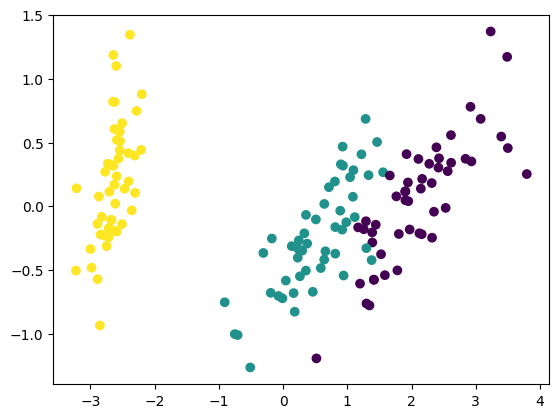

In [664]:
plt.scatter(iris_p['x'],iris_p['y'],label=s2,c=s2)

plt.show()


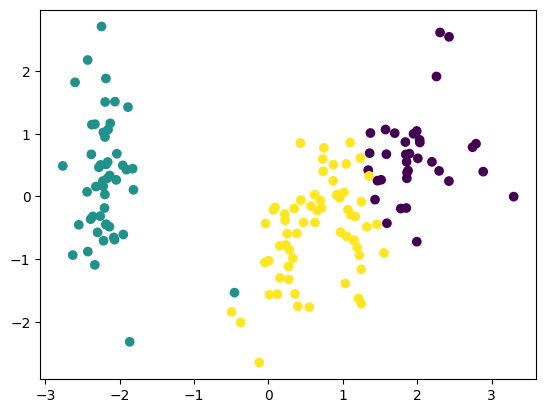

In [665]:
plt.scatter(iris_p2['x'],iris_p2['y'],label=s2,c=b2[:-1])
plt.show()


c:\Program Files\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program Files\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


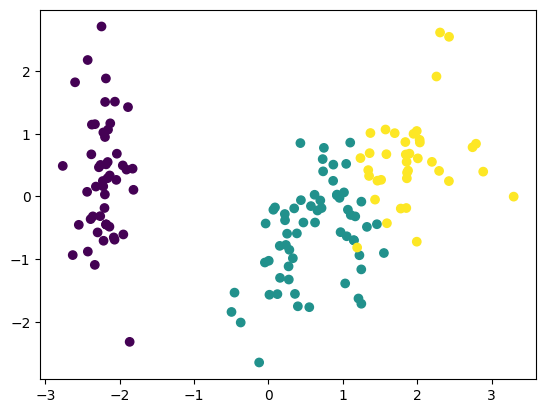

In [666]:
from sklearn.cluster import KMeans
kmeans3 = KMeans(n_clusters=3)
kmeans2 = KMeans(n_clusters=2)
b3 = kmeans3.fit_predict(iris_numeric)
b4 = kmeans2.fit_predict(iris_numeric)

plt.scatter(iris_p2['x'],iris_p2['y'],label=s2,c=b3)

plt.show()


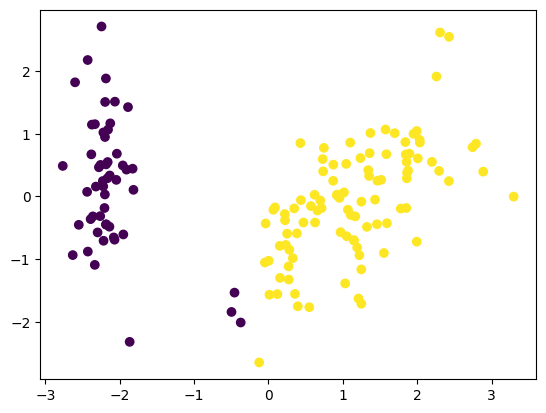

In [667]:
plt.scatter(iris_p2['x'],iris_p2['y'],label=s2,c=b4)

plt.show()


In [684]:
from sklearn.metrics import classification_report
#این قسمت را دستی انجام می دهم برای درست کردن عدد لیبل خوشه بندی ها اگر بخواهید دوباره اجرا کنید باید این قسمت را دوباره دستی انجام دهید
zeros = np.where(b3 == 0)
ones = np.where(b3==1)
twos = np.where(b3 == 2)
for z in zeros:
    b3[z] = 2
for o in twos:
    b3[o] = 0


[[36 14  0]
 [ 2 48  0]
 [ 0  0 50]]
              precision    recall  f1-score   support

           0       0.95      0.72      0.82        50
           1       0.77      0.96      0.86        50
           2       1.00      1.00      1.00        50

    accuracy                           0.89       150
   macro avg       0.91      0.89      0.89       150
weighted avg       0.91      0.89      0.89       150



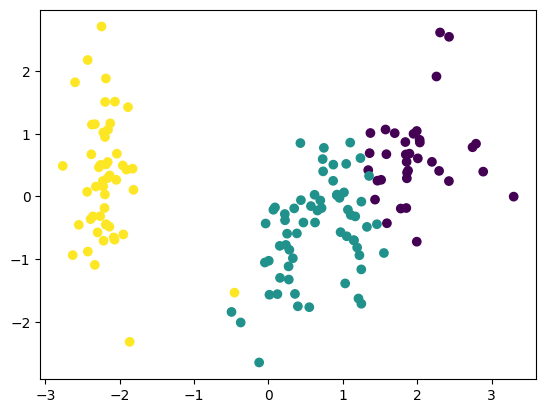

In [685]:
print(confusion_matrix(s2,b3))
print(classification_report(s2,b3))
plt.scatter(iris_p2['x'],iris_p2['y'],label=s2,c=b2[:-1])
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        50
           1       0.77      0.98      0.86        50
           2       0.98      1.00      0.99        50

    accuracy                           0.89       150
   macro avg       0.92      0.89      0.89       150
weighted avg       0.92      0.89      0.89       150

              precision    recall  f1-score   support

           0       0.95      0.72      0.82        50
           1       0.77      0.96      0.86        50
           2       1.00      1.00      1.00        50

    accuracy                           0.89       150
   macro avg       0.91      0.89      0.89       150
weighted avg       0.91      0.89      0.89       150



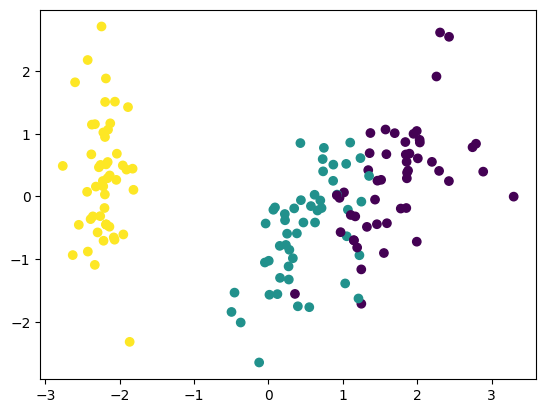

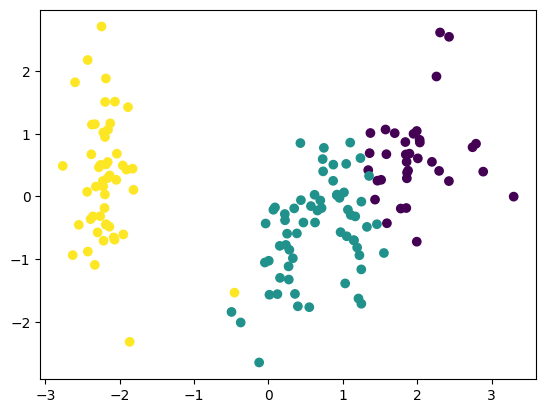

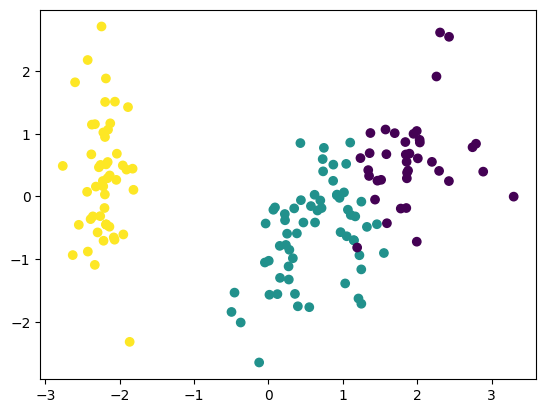

In [687]:

print(classification_report(s2,b2[:-1]))

print(classification_report(s2,b3))
plt.scatter(iris_p2['x'],iris_p2['y'],c=s2)

plt.show()
plt.scatter(iris_p2['x'],iris_p2['y'],c=b2[:-1])

plt.show()
plt.scatter(iris_p2['x'],iris_p2['y'],c=b3)

plt.show()
